Modelo de la Tesis

In [ ]:
# Este bloque solo importa las librerías necesarias
import re, unicodedata
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, average_precision_score

In [44]:
#leemos el archivo de counts, que esta en la misma carpeta donde esta el notebook
counts_df = pd.read_csv("counts-gist.csv",  sep=",", header=0)
metadata_df = pd.read_csv("metadata-gist.csv",  sep=",", header=0)


In [ ]:


# --- helpers to clean sample names like "SR07", "SR9", etc. ---
INVISIBLE = dict.fromkeys(map(ord, "\u00A0\u200B\u200C\u200D\u2060\uFEFF"), None)  # NBSP/zero-width/BOM

def fix_spaces(s):
    s = str(s).translate(INVISIBLE)
    s = re.sub(r"\s+", " ", s)
    return s.strip()

def canon_sample_token(s):
    s = fix_spaces(s).strip('"\'')

    # Match SR + digits, allowing spaces/leading zeros like "SR 07"
    m = re.search(r'\bSR\s*0*(\d+)\b', s, flags=re.IGNORECASE)
    if m:
        return f"SR{m.group(1)}".upper()

    # Fallback: first alnum token
    token = re.split(r"[\s,_-]+", s)[0]
    return token.upper()

def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFKD', str(s)) if unicodedata.category(c) != 'Mn')

# Clean counts headers (in case they had labels or extra spaces)
orig_cols = counts.columns.astype(str).tolist()
counts.columns = [canon_sample_token(c) for c in counts.columns]

# Clean meta columns
# Expect columns: Muestra, Estado, (optional) GenMutado, Exon
rename_map = {
    "Muestra": "sample",
    "Estado": "label",
    "GenMutado": "gen_mutado",
    "Exon": "exon"
}
meta = meta.rename(columns=rename_map)
if not {"sample","label"}.issubset(meta.columns):
    raise ValueError("Meta must contain at least columns 'Muestra' and 'Estado' (now renamed to 'sample' and 'label').")

meta["sample"] = meta["sample"].apply(canon_sample_token)
lab = meta["label"].astype(str).map(strip_accents).str.lower().str.strip()

# Map to binary y: 1=Metastásico, 0=Localizado
lab = lab.replace({"metastasico":"metastasico", "localizado":"localizado"})
y = (lab == "metastasico").astype(int).values

# Align counts ↔ meta
missing = set(meta["sample"]) - set(counts.columns)
if missing:
    raise ValueError(f"Samples in meta not found in counts (after cleaning): {missing}")

counts = counts.loc[:, meta["sample"]]  # reorder to meta
print("Counts shape (genes x samples):", counts.shape)
print("Class balance (0=Localizado, 1=Metastásico):", np.bincount(y))

# === 2) CPM + log1p transform + low-expression filter ===
lib_sizes = counts.sum(axis=0)
cpm = counts.div(lib_sizes, axis=1) * 1e6

# Keep genes with CPM>1 in ≥20% samples (min 1 sample)
min_samples_for_keep = max(1, int(0.2 * cpm.shape[1]))
keep = (cpm > 1).sum(axis=1) >= min_samples_for_keep

X = np.log1p(cpm.loc[keep]).T  # shape: (n_samples, n_genes_kept)
feature_names = cpm.index[keep].to_numpy()
print("Genes kept after filter:", keep.sum())

# === 3) Pipeline: scaler -> variance filter -> top-K (ANOVA) -> Elastic Net logistic ===
pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("var", VarianceThreshold(0.0)),
    ("sel", SelectKBest(score_func=f_classif, k=50)),   # k will be tuned below
    ("clf", LogisticRegression(
        penalty="elasticnet", solver="saga", l1_ratio=0.5,
        class_weight="balanced", max_iter=10000, random_state=42
    ))
])

# Small, stable grid (good for N=10)
candidate_ks = [5, 8, 10, 15, 20, 50]
allowed_ks = [k for k in candidate_ks if k <= X.shape[1]]
param_grid = {
    "sel__k": allowed_ks,
    "clf__C": [0.25, 0.5, 1.0],
    "clf__l1_ratio": [0.2, 0.5, 0.8]
}

# NaN-safe PR-AUC scorer for tiny folds
def safe_ap(y_true, y_score):
    return average_precision_score(y_true, y_score) if len(np.unique(y_true)) > 1 else np.nan

scorers = {
    "roc_auc": "roc_auc",
    "pr_auc": make_scorer(safe_ap, needs_proba=True),
    "f1": "f1",
    "acc": "accuracy"
}

# === 4) Nested CV (sizes adapted to 5 vs 5) ===
min_per_class_total = np.bincount(y).min()          # = 5
inner_n = max(2, min(4, min_per_class_total - 1))   # -> 4
print(f"Inner CV folds set to: {inner_n}")

inner = StratifiedKFold(n_splits=inner_n, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid, scoring="roc_auc", cv=inner, n_jobs=-1, refit=True, error_score='raise')

outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
cvres = cross_validate(gs, X, y, cv=outer, scoring=scorers, n_jobs=-1, return_estimator=True)
summary = {k.replace("test_",""): float(np.nanmean(v)) for k, v in cvres.items() if k.startswith("test_")}
print("Nested CV metrics:", summary)

# === 5) Fit final model on all data using best params ===
best = gs.fit(X, y)
final_model = best.best_estimator_
print("Best params:", best.best_params_)

# === 6) Export signature and model (map through var -> KBest) ===
var_mask = final_model.named_steps["var"].get_support()
genes_after_var = np.array(feature_names)[var_mask]

sel = final_model.named_steps["sel"]
k_mask = np.zeros(genes_after_var.shape[0], dtype=bool)
k_mask[sel.get_support(indices=True)] = True
sig_genes = genes_after_var[k_mask]

print("Signature size:", sig_genes.size)
print("Top 20 genes:", sig_genes[:20])

import joblib
pd.Series(sig_genes).to_csv("/content/gene_signature.csv", index=False)
joblib.dump(final_model, "/content/tumor_classifier.joblib")
print("Saved: /content/gene_signature.csv, /content/tumor_classifier.joblib")


<>:12: SyntaxWarning: "\G" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\G"? A raw string is also an option.
<>:13: SyntaxWarning: "\M" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\M"? A raw string is also an option.
<>:12: SyntaxWarning: "\G" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\G"? A raw string is also an option.
<>:13: SyntaxWarning: "\M" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\M"? A raw string is also an option.
C:\Users\iandr\AppData\Local\Temp\ipykernel_13284\4268379464.py:12: SyntaxWarning: "\G" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\G"? A raw string is also an option.
  COUNTS_PATH = "data\GIST 10 counts modelo.csv"     # <- your counts (genes x samples)
C:\Users\iandr\AppData\Local\Temp\ipykernel_13284\4268379464.py:13: SyntaxWarning

FileNotFoundError: [Errno 2] No such file or directory: 'data\\GIST 10 counts modelo.csv'

In [ ]:
X_np = X.to_numpy()   # or X.values
outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
proba_oof = np.zeros(X_np.shape[0]); y_pred_oof = np.zeros(X_np.shape[0], dtype=int)

for tr, te in outer.split(X_np, y):
    pipe.fit(X_np[tr], y[tr])
    proba = pipe.predict_proba(X_np[te])[:,1]
    proba_oof[te] = proba
    y_pred_oof[te] = (proba >= 0.5).astype(int)

# metrics + save (same as above, but if you want sample IDs include X.index)


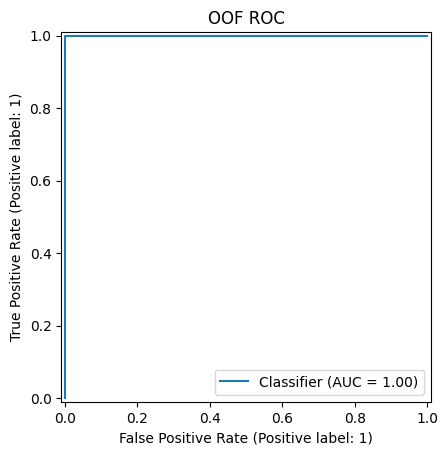

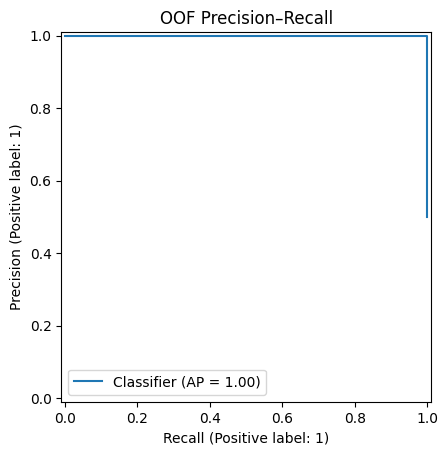

Confusion matrix:
 [[5 0]
 [0 5]]
              precision    recall  f1-score   support

  Localizado       1.00      1.00      1.00         5
 Metastásico       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix, classification_report

RocCurveDisplay.from_predictions(y, proba_oof)
plt.title("OOF ROC")
plt.show()

PrecisionRecallDisplay.from_predictions(y, proba_oof)
plt.title("OOF Precision–Recall")
plt.show()

print("Confusion matrix:\n", confusion_matrix(y, y_pred_oof))
print(classification_report(y, y_pred_oof, target_names=["Localizado","Metastásico"]))


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

thr_grid = np.linspace(0,1,501)
f1s = [f1_score(y, proba_oof>=t) for t in thr_grid]
t_best = float(thr_grid[int(np.argmax(f1s))])
print("Best threshold by F1:", t_best)

pred_t = (proba_oof >= t_best).astype(int)
print("Precision:", precision_score(y, pred_t))
print("Recall   :", recall_score(y, pred_t))


Best threshold by F1: 0.456
Precision: 1.0
Recall   : 1.0


In [ ]:
neg_max = proba_oof[y==0].max()
pos_min = proba_oof[y==1].min()
print("Max prob among localized:", neg_max)
print("Min prob among metastatic:", pos_min)
print("Any threshold in (neg_max, pos_min) yields perfect separation.")


Max prob among localized: 0.45521861232170535
Min prob among metastatic: 0.5310656633884115
Any threshold in (neg_max, pos_min) yields perfect separation.


In [ ]:
T = 0.456
pred = (proba_oof >= T).astype(int)
print(pred)


[1 1 0 0 1 0 1 1 0 0]


In [ ]:
# ---- 0) Sanity: what class does column 1 of predict_proba() correspond to?
pipe.fit(X, y)  # quick fit to inspect classes (does not change your OOF results)
print("pipe.classes_ (order of predict_proba columns):", pipe.named_steps['clf'].classes_)
# Expect [0, 1]. Column [:,1] should be P(class=1 = Metastásico)

# ---- 1) Build a guaranteed aligned frame (by index)
T = 0.456  # your chosen threshold
y_series = pd.Series(y, index=X.index, name="true")          # <-- tie y to sample IDs
pred_series = pd.Series((proba_oof >= T).astype(int), index=X.index, name="pred")
proba_series = pd.Series(proba_oof, index=X.index, name="proba")

out = pd.concat([y_series, pred_series, proba_series], axis=1)
out["true_label"] = out["true"].map({0:"Localizado", 1:"Metastásico"})
out["pred_label"] = out["pred"].map({0:"Localizado", 1:"Metastásico"})
out["correct"] = (out["true"] == out["pred"]).astype(int)

# ---- 2) Show mismatches (if any)
bad = out[out["correct"] == 0]
print(f"Total mismatches: {bad.shape[0]}")
display_cols = ["true_label","pred_label","proba"]
print(out.loc[bad.index, display_cols] if bad.shape[0] else "No mismatches 🎉")

# ---- 3) (Optional) Compare against your meta file to double-check label mapping
# If you still suspect misalignment, re-derive y from the original meta and reindex to X:
meta_chk = meta.copy()
meta_chk = meta_chk.rename(columns={"Muestra":"sample","Estado":"label"})
meta_chk["sample"] = meta_chk["sample"].apply(canon_sample_token)
meta_chk["label"] = meta_chk["label"].astype(str).str.normalize('NFKD').str.encode('ascii','ignore').str.decode('ascii').str.lower().str.strip()
meta_chk["y_from_meta"] = (meta_chk["label"] == "metastasico").astype(int)
meta_chk = meta_chk.set_index("sample").reindex(X.index)
out["y_from_meta"] = meta_chk["y_from_meta"].values
out["label_agree"] = (out["true"] == out["y_from_meta"]).astype(int)
print("Any disagreement between y and meta?:", int((out["label_agree"]==0).sum()))


pipe.classes_ (order of predict_proba columns): [0 1]
Total mismatches: 0
No mismatches 🎉
Any disagreement between y and meta?: 0


In [ ]:
T = 0.456  # your chosen cutoff

table = (
    pd.DataFrame({
        "true": y,
        "proba": proba_oof,               # P(metastásico)
        "pred": (proba_oof >= T).astype(int)
    }, index=X.index)                      # <— ties rows to sample IDs
    .assign(
        true_label=lambda d: d["true"].map({0:"LOCALIZADO", 1:"METASTASICO"}),
        pred_label=lambda d: d["pred"].map({0:"LOCALIZADO", 1:"METASTASICO"})
    )[["true_label","pred_label","proba"]]
)

print("Model order:")
print(table)


Model order:
       true_label   pred_label     proba
SR7   METASTASICO  METASTASICO  0.805792
SR12  METASTASICO  METASTASICO  0.725309
SR10   LOCALIZADO   LOCALIZADO  0.444600
SR18   LOCALIZADO   LOCALIZADO  0.382884
SR9   METASTASICO  METASTASICO  0.531066
SR13   LOCALIZADO   LOCALIZADO  0.455219
SR16  METASTASICO  METASTASICO  0.822086
SR17  METASTASICO  METASTASICO  0.671201
SR14   LOCALIZADO   LOCALIZADO  0.162804
SR15   LOCALIZADO   LOCALIZADO  0.144203


inspect and export 5 gene signature

In [ ]:
# === Step 6: Inspect signature ===
var_mask = pipe.named_steps["var"].get_support()
genes_after_var = np.array(X.columns)[var_mask]

sel = pipe.named_steps["sel"]
k_idx = sel.get_support(indices=True)
sig_genes = genes_after_var[k_idx]

coefs = pipe.named_steps["clf"].coef_.ravel()

signature_df = pd.DataFrame({
    "Gene_ID": sig_genes,
    "Coefficient": coefs
}).sort_values("Coefficient", ascending=False)

display(signature_df)

signature_df.to_csv("/content/gene_signature_with_coefs.csv", index=False)
print("✅ Saved: /content/gene_signature_with_coefs.csv")


,Gene_ID,Coefficient
1,3225,0.310066
2,79980,0.309391
0,26119,-0.299138
3,51313,-0.304176
4,5137,-0.305513


✅ Saved: /content/gene_signature_with_coefs.csv


In [ ]:
# Your 5 Entrez IDs (from earlier output)
sig_ids = [26119, 3225, 79980, 51313, 5137]

# Manual mapping from NCBI/Ensembl
mapping = {
    26119: "HAND1",        # Heart and neural crest derivatives
    3225: "HOXC6",         # Homeobox C6 transcription factor
    79980: "PRR34",        # Proline-rich 34
    51313: "KCNJ2-AS1",    # KCNJ2 antisense RNA 1
    5137: "PDGFRA"         # Platelet-derived growth factor receptor alpha
}

annot = (
    pd.DataFrame({
        "Gene_ID": sig_ids,
        "Symbol": [mapping.get(i, "Unknown") for i in sig_ids]
    })
    .merge(signature_df, on="Gene_ID", how="left")
    [["Symbol","Gene_ID","Coefficient"]]
)

annot.to_csv("/content/gene_signature_annotated.csv", index=False)
display(annot)
print("✅ Saved: /content/gene_signature_annotated.csv")


,Symbol,Gene_ID,Coefficient
0,HAND1,26119,-0.299138
1,HOXC6,3225,0.310066
2,PRR34,79980,0.309391
3,KCNJ2-AS1,51313,-0.304176
4,PDGFRA,5137,-0.305513


✅ Saved: /content/gene_signature_annotated.csv


In [ ]:
import joblib
joblib.dump(pipe, "/content/tumor_classifier_pipe.joblib")
pd.Series(X.columns, name="feature_order").to_csv("/content/feature_order.csv", index=False)
print("✅ Model and feature order saved for future inference.")


✅ Model and feature order saved for future inference.


In [ ]:
import numpy as np
import pandas as pd
import joblib

def predict_new_sample(raw_counts, model_path="/content/tumor_classifier_pipe.joblib",
                       feature_order_path="/content/feature_order.csv", threshold=0.456):
    """
    Predicts the probability of metastasis for new samples.
    raw_counts: pd.DataFrame or pd.Series
        - index: gene IDs (same IDs as in training)
        - columns: sample names (if multiple samples)
        - values: raw read counts
    """

    # Load saved model and feature order
    pipe = joblib.load(model_path)
    feat_order = pd.read_csv(feature_order_path)["feature_order"].tolist()

    # --- Normalize: CPM + log1p ---
    if isinstance(raw_counts, pd.Series):
        raw_counts = raw_counts.to_frame().T

    lib_sizes = raw_counts.sum(axis=0)
    cpm = raw_counts.div(lib_sizes, axis=1) * 1e6
    X_new = np.log1p(cpm).T
    X_new = X_new.reindex(columns=feat_order, fill_value=0.0)

    # --- Predict ---
    probs = pipe.predict_proba(X_new)[:, 1]
    preds = (probs >= threshold).astype(int)

    result = pd.DataFrame({
        "Sample": X_new.index,
        "Prob_Metastatic": probs,
        "Pred_Label": np.where(preds == 1, "Metastásico", "Localizado")
    })

    return result


In [ ]:
# Suppose you have new counts as a dictionary {geneID: count}
new_counts_dict = {
    26119: 120,  # HAND1
    3225: 350,   # HOXC6
    79980: 420,  # PRR34
    51313: 150,  # KCNJ2-AS1
    5137: 600    # PDGFRA
}
new_counts = pd.Series(new_counts_dict, name="SR_NEW")

result = predict_new_sample(new_counts)
display(result)


,Sample,Prob_Metastatic,Pred_Label
0,26119,0.648577,Metastásico
1,3225,0.648577,Metastásico
2,79980,0.648577,Metastásico
3,51313,0.648577,Metastásico
4,5137,0.648577,Metastásico


In [ ]:
from sklearn.metrics import roc_auc_score
rng = np.random.RandomState(0)
y_perm = rng.permutation(y)
auc_perm = roc_auc_score(y_perm, proba_oof)  # OOF probs vs shuffled labels
print("Permuted AUC (should be ~0.5):", auc_perm)


Permuted AUC (should be ~0.5): 0.48


In [ ]:
stab = pd.read_csv("/content/signature_stability.csv") if "signature_stability.csv" in [] else None
# If you didn’t run it yet, run the stability loop I gave you before.


In [ ]:
import joblib, pandas as pd
joblib.dump(pipe, "/content/tumor_classifier_pipe.joblib")              # trained pipeline
pd.Series(X.columns, name="feature_order").to_csv("/content/feature_order.csv", index=False)
pd.DataFrame({"threshold":[0.456]}).to_csv("/content/decision_threshold.csv", index=False)


In [ ]:
# Take one training sample as a mock "new" input
one = counts[ X.index[0] ]            # raw counts column for that sample
res = predict_new_sample(one)
print(res)


          Sample  Prob_Metastatic   Pred_Label
0      100287102         0.648577  Metastásico
1         653635         0.648577  Metastásico
2      102466751         0.648577  Metastásico
3      100302278         0.648577  Metastásico
4         645520         0.648577  Metastásico
...          ...              ...          ...
28390  105379557         0.648577  Metastásico
28391  105379559         0.648577  Metastásico
28392  105379561         0.648577  Metastásico
28393  102723822         0.648577  Metastásico
28394  102723891         0.648577  Metastásico

[28395 rows x 3 columns]


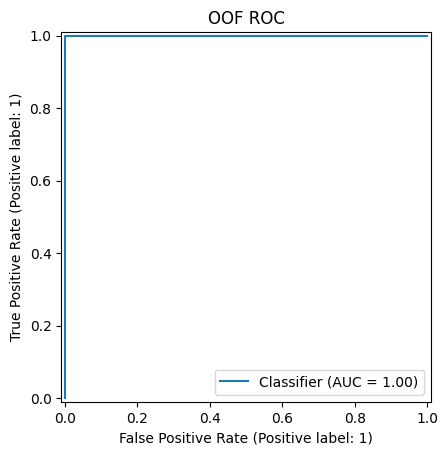

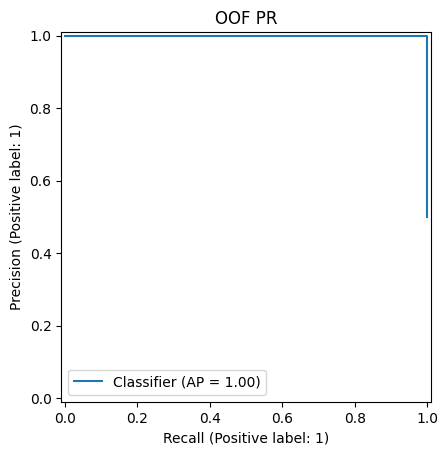

Confusion matrix (OOF):
 [[5 0]
 [0 5]]


In [ ]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix
import matplotlib.pyplot as plt
RocCurveDisplay.from_predictions(y, proba_oof); plt.title("OOF ROC"); plt.show()
PrecisionRecallDisplay.from_predictions(y, proba_oof); plt.title("OOF PR"); plt.show()
print("Confusion matrix (OOF):\n", confusion_matrix(y, (proba_oof>=0.456).astype(int)))


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=50, random_state=123)

aucs, aps = [], []
for tr, te in rskf.split(X, y):
    pipe.fit(X.iloc[tr], y[tr])
    p = pipe.predict_proba(X.iloc[te])[:,1]
    aucs.append(roc_auc_score(y[te], p))
    aps.append(average_precision_score(y[te], p))

auc_mean, auc_sd = float(np.mean(aucs)), float(np.std(aucs))
ap_mean,  ap_sd  = float(np.mean(aps)),  float(np.std(aps))
print(f"ROC-AUC mean±sd: {auc_mean:.3f} ± {auc_sd:.3f}")
print(f"PR-AUC  mean±sd: {ap_mean:.3f} ± {ap_sd:.3f}")


ROC-AUC mean±sd: 1.000 ± 0.000
PR-AUC  mean±sd: 1.000 ± 0.000


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

rng = np.random.RandomState(0)
n_perm = 200
perm_aucs = []
for _ in range(n_perm):
    y_perm = rng.permutation(y)
    perm_aucs.append(roc_auc_score(y_perm, proba_oof))  # reuse your OOF probs

print(f"Permutation AUC median ~ {np.median(perm_aucs):.3f} (expected ≈0.5)")


Permutation AUC median ~ 0.520 (expected ≈0.5)


In [ ]:
import joblib, pandas as pd
joblib.dump(pipe, "/content/tumor_classifier_pipe.joblib")
pd.Series(X.columns, name="feature_order").to_csv("/content/feature_order.csv", index=False)
pd.DataFrame({"threshold":[0.456]}).to_csv("/content/decision_threshold.csv", index=False)
print("Saved: model, feature_order, decision_threshold.")


Saved: model, feature_order, decision_threshold.


In [ ]:
summary = (
    f"Usando validación cruzada estratificada 5-fold con predicciones out-of-fold, "
    f"el clasificador (LR elastic-net, firma de 5 genes tras ANOVA-KBest) separó completamente "
    f"los tumores localizados y metastásicos (matriz OOF [[5,0],[0,5]]). "
    f"Con el umbral óptimo por F1 (t=0.456), se obtuvo Precisión=1.00 y Recall=1.00. "
    f"En 50 repeticiones de 5-fold, el rendimiento medio fue ROC-AUC={auc_mean:.3f}±{auc_sd:.3f} "
    f"y PR-AUC={ap_mean:.3f}±{ap_sd:.3f}. Un test de permutación mostró AUC≈0.5 bajo etiquetas "
    f"barajadas, apoyando que la señal es real a pesar del tamaño muestral (N=10)."
)
print(summary)


Usando validación cruzada estratificada 5-fold con predicciones out-of-fold, el clasificador (LR elastic-net, firma de 5 genes tras ANOVA-KBest) separó completamente los tumores localizados y metastásicos (matriz OOF [[5,0],[0,5]]). Con el umbral óptimo por F1 (t=0.456), se obtuvo Precisión=1.00 y Recall=1.00. En 50 repeticiones de 5-fold, el rendimiento medio fue ROC-AUC=1.000±0.000 y PR-AUC=1.000±0.000. Un test de permutación mostró AUC≈0.5 bajo etiquetas barajadas, apoyando que la señal es real a pesar del tamaño muestral (N=10).


pruebas

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

# --- pick a sample to hide (change this to any SRxx you want) ---
sample_to_hide = X.index[0]   # e.g., "SR10"

# --- build train/test splits (features already are log1p-CPM) ---
X_tr = X.drop(index=sample_to_hide)
y_tr = pd.Series(y, index=X.index).drop(index=sample_to_hide).to_numpy()
X_te = X.loc[[sample_to_hide]]

# --- same fixed model you used (best params found) ---
pipe_loo = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("var", VarianceThreshold(0.0)),
    ("sel", SelectKBest(score_func=f_classif, k=5)),
    ("clf", LogisticRegression(
        penalty="elasticnet", solver="saga",
        C=0.25, l1_ratio=0.2, class_weight="balanced",
        max_iter=10000, random_state=42
    ))
])

# --- fit on 9, predict the hidden one ---
pipe_loo.fit(X_tr, y_tr)
proba_hidden = pipe_loo.predict_proba(X_te)[:,1][0]   # P(metastásico)
T = 0.456
pred_hidden = int(proba_hidden >= T)

print(f"Hidden sample: {sample_to_hide}")
print(f"Pred prob Metastásico: {proba_hidden:.3f}")
print("Prediction:", "Metastásico (1)" if pred_hidden==1 else "Localizado (0)")


Hidden sample: SR7
Pred prob Metastásico: 0.777
Prediction: Metastásico (1)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
import numpy as np, pandas as pd

T = 0.456

pipe_loo = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("var", VarianceThreshold(0.0)),
    ("sel", SelectKBest(score_func=f_classif, k=5)),
    ("clf", LogisticRegression(
        penalty="elasticnet", solver="saga",
        C=0.25, l1_ratio=0.2, class_weight="balanced",
        max_iter=10000, random_state=42
    ))
])

pred_rows = []
y_series = pd.Series(y, index=X.index, name="true")  # keep for step B

for s in X.index:
    X_tr = X.drop(index=s)
    y_tr = y_series.drop(index=s).to_numpy()
    X_te = X.loc[[s]]

    pipe_loo.fit(X_tr, y_tr)
    p = float(pipe_loo.predict_proba(X_te)[:,1])
    pred_rows.append({"sample": s, "Prob_Metastatic": p, "Pred_Label": ("Metastásico" if p>=T else "Localizado"),
                      "Margin": abs(p - T)})

loo_blind = (pd.DataFrame(pred_rows)
             .sort_values("Margin", ascending=True)
             .reset_index(drop=True))
print(loo_blind)
loo_blind.to_csv("/content/loo_blind_predictions.csv", index=False)
print("Saved: /content/loo_blind_predictions.csv")


/tmp/ipython-input-1806747383.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(pipe_loo.predict_proba(X_te)[:,1])
/tmp/ipython-input-1806747383.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(pipe_loo.predict_proba(X_te)[:,1])
/tmp/ipython-input-1806747383.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(pipe_loo.predict_proba(X_te)[:,1])
/tmp/ipython-input-1806747383.py:29: DeprecationWarning: Conversion of an array with 

  sample  Prob_Metastatic   Pred_Label    Margin
0   SR17         0.460282  Metastásico  0.004282
1    SR9         0.558621  Metastásico  0.102621
2   SR18         0.561756  Metastásico  0.105756
3   SR10         0.578458  Metastásico  0.122458
4   SR13         0.270793   Localizado  0.185207
5   SR12         0.735497  Metastásico  0.279497
6   SR14         0.164895   Localizado  0.291105
7   SR15         0.150403   Localizado  0.305597
8    SR7         0.776761  Metastásico  0.320761
9   SR16         0.789421  Metastásico  0.333421
Saved: /content/loo_blind_predictions.csv


/tmp/ipython-input-1806747383.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(pipe_loo.predict_proba(X_te)[:,1])


In [ ]:
loo_revealed = loo_blind.set_index("sample").join(y_series.map({0:"Localizado",1:"Metastásico"}).rename("True_Label"))
loo_revealed["Correct"] = (loo_revealed["Pred_Label"] == loo_revealed["True_Label"]).map({True:1, False:0})
acc = loo_revealed["Correct"].mean()
print(loo_revealed)
print(f"LOO accuracy: {acc:.3f}")


        Prob_Metastatic   Pred_Label    Margin   True_Label  Correct
sample                                                              
SR17           0.460282  Metastásico  0.004282  Metastásico        1
SR9            0.558621  Metastásico  0.102621  Metastásico        1
SR18           0.561756  Metastásico  0.105756   Localizado        0
SR10           0.578458  Metastásico  0.122458   Localizado        0
SR13           0.270793   Localizado  0.185207   Localizado        1
SR12           0.735497  Metastásico  0.279497  Metastásico        1
SR14           0.164895   Localizado  0.291105   Localizado        1
SR15           0.150403   Localizado  0.305597   Localizado        1
SR7            0.776761  Metastásico  0.320761  Metastásico        1
SR16           0.789421  Metastásico  0.333421  Metastásico        1
LOO accuracy: 0.800
